In [3]:
import paddle
import paddle.nn as nn

from paddle.io import Dataset
from paddle.static import InputSpec

import paddle.fluid as fluid

from paddle.fluid.dygraph import Linear
from paddle.fluid.dygraph import Layer, to_variable
import paddle.fluid.dygraph as dygraph
import gc
import numpy as np
import pandas as pd
import os
import argparse
import random

/Users/chenguibin/anaconda3/lib/python3.7/site-packages/socks.py:58: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Callable


In [4]:

class Scaler(object):
    """
    Desc: Normalization utilities
    """
    def __init__(self):
        self.mean = 0.
        self.std = 1.

    def fit(self, data):
        # type: (paddle.tensor) -> None
        """
        Desc:
            Fit the data
        Args:
            data:
        Returns:
            None
        """
        self.mean = np.mean(data)
        self.std = np.std(data)

    def transform(self, data):
        # type: (paddle.tensor) -> paddle.tensor
        """
        Desc:
            Transform the data
        Args:
            data:
        Returns:
            The transformed data
        """
        mean = paddle.to_tensor(self.mean).type_as(data).to(data.device) if paddle.is_tensor(data) else self.mean
        std = paddle.to_tensor(self.std).type_as(data).to(data.device) if paddle.is_tensor(data) else self.std
        return (data - mean) / std

    def inverse_transform(self, data):
        # type: (paddle.tensor) -> paddle.tensor
        """
        Desc:
            Restore to the original data
        Args:
            data: the transformed data
        Returns:
            The original data
        """
        mean = paddle.to_tensor(self.mean) if paddle.is_tensor(data) else self.mean
        std = paddle.to_tensor(self.std) if paddle.is_tensor(data) else self.std
        return (data * std) + mean


In [5]:
from sklearn import preprocessing

class WindTurbineDataset(Dataset):
    """
    Desc: Data preprocessing,
          Here, e.g.    15 days for training,
                        3 days for validation,
                        and 6 days for testing
    """
    def __init__(self, data_path,
                 filename='my.csv',
                 flag='train',
                 size=None,
                 turbine_id=0,
                 task='MS',
                 target='Target',
                 scale=True,
                 start_col=3,       # the start column index of the data one aims to utilize
                 day_len=24 * 6,
                 train_days=15,     # 15 days
                 val_days=3,        # 3 days
                 test_days=6,       # 6 days
                 total_days=30      # 30 days
                 ):
        super().__init__()  
        self.unit_size = day_len   
        if size is None:
            self.input_len = self.unit_size   
            self.output_len = self.unit_size    
        else:
            self.input_len = size[0]
            self.output_len = size[1]
        # initialization
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]
        self.task = task
        self.target = target
        self.scale = scale
        self.start_col = start_col
        self.data_path = data_path
        self.filename = filename
        self.tid = turbine_id

        # If needed, we employ the predefined total_size (e.g. one month)
        self.total_size = self.unit_size * total_days   
        #
        self.train_size = train_days * self.unit_size   
        self.val_size = val_days * self.unit_size
        self.test_size = test_days * self.unit_size
        # self.test_size = self.total_size - train_size - val_size
        #
        # Or, if total_size is unavailable:
        # self.total_size = self.train_size + self.val_size + self.test_size
        self.__read_data__()

    def __read_data__(self):
        self.scaler = preprocessing.StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.data_path, self.filename))
        
        df_raw['Tmstamp'] = pd.to_datetime(df_raw['Tmstamp'])
        df_raw.insert(0, 'hour',df_raw['Tmstamp'].dt.hour)
        df_raw.insert(1, 'minute',df_raw['Tmstamp'].dt.minute)
        del df_raw['Tmstamp']
        del df_raw['Day']
        df_raw.insert(3, 't_sin',np.sin((df_raw['hour']*6+df_raw['minute']/10)*2*np.pi/(24*6)))
        df_raw.insert(4, 't_cos',np.cos((df_raw['hour']*6+df_raw['minute']/10)*2*np.pi/(24*6)))
        
        while df_raw.isna().sum().sum()>0:
            df_raw = df_raw.fillna(axis=0, method='ffill')
            df_raw = df_raw.fillna(axis=0,method='bfill')
        
        border1s = [self.tid * self.total_size,   
                    self.tid * self.total_size + self.train_size - self.input_len,
                    self.tid * self.total_size + self.train_size + self.val_size - self.input_len
                    ]
        border2s = [self.tid * self.total_size + self.train_size,
                    self.tid * self.total_size + self.train_size + self.val_size,
                    self.tid * self.total_size + self.train_size + self.val_size + self.test_size
                    ]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        df_data = df_raw
        if self.task == 'M':
            cols_data = df_raw.columns[5:]   
            df_data = df_raw[cols_data]
        elif self.task == 'MS':
            cols_data = df_raw.columns[5:]   
            df_data = df_raw[cols_data]
        elif self.task == 'S':
            df_data = df_raw[[self.tid, self.target]]

        # Turn off the SettingWithCopyWarning
        pd.set_option('mode.chained_assignment', None)

        df_data.replace(to_replace=np.nan, value=0, inplace=True)

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            #self.scaler.fit(train_data.values) 
            data = self.scaler.fit_transform(df_data.values)  
        else:
            data = df_data.values
        
        data = np.hstack((df_raw.values[:,3:5],data))
        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]  
        self.raw_data = df_data[border1 + self.input_len:border2]  

    def get_raw_data(self):
        return self.raw_data

    def __getitem__(self, index):    
        #
        # Only for customized use.
        # When sliding window not used, e.g. prediction without overlapped input/output sequences
        if self.set_type >= 3:
            index = index * self.output_len
        #
        # Standard use goes here.
        # Sliding window with the size of input_len + output_len
        s_begin = index
        s_end = s_begin + self.input_len
        r_begin = s_end
        r_end = r_begin + self.output_len
 
        seq_x1 = self.data_x[s_begin:s_end]   
        seq_x2 = self.data_y[r_begin:r_end,:2] #
        seq_y = self.data_y[r_begin:r_end]  
        return [seq_x1,seq_x2], seq_y
        #return seq_x, seq_y

    def __len__(self):
        # In our case, the sliding window is adopted, the number of samples is calculated as follows
        if self.set_type < 3:
            return len(self.data_x) - self.input_len - self.output_len + 1
        # Otherwise, if sliding window is not adopted
        return int((len(self.data_x) - self.input_len) / self.output_len)

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)


/Users/chenguibin/anaconda3/lib/python3.7/site-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/Users/chenguibin/anaconda3/lib/python3.7/site-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/Users/chenguibin/anaconda3/lib/python3.7/site-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://nu

In [6]:

def prep_env():
    # type: () -> dict
    """
    Desc:
        Prepare the experimental settings
    Returns:
        The initialized arguments
    """
    parser = argparse.ArgumentParser(description='Long Term Wind Power Forecasting')
    ###
    parser.add_argument('--data_path', type=str, default='./data/', help='Path to the data file')
    parser.add_argument('--filename', type=str, default='wtbdata_245days.csv',
                        help='Filename of the input data, change it if necessary')
    parser.add_argument('--task', type=str, default='MS', help='The type of forecasting task, '
                                                               'options:[M, S, MS]; '
                                                               'M: multivariate --> multivariate, '
                                                               'S: univariate --> univariate, '
                                                               'MS: multivariate --> univariate')
    parser.add_argument('--target', type=str, default='Patv', help='Target variable in S or MS task')
    parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='Location of model checkpoints')
    parser.add_argument('--input_len', type=int, default=24, help='Length of the input sequence')
    parser.add_argument('--output_len', type=int, default=24, help='The length of predicted sequence')
    parser.add_argument('--start_col', type=int, default=3, help='Index of the start column of the meaningful variables')
    parser.add_argument('--in_var', type=int, default=12, help='Number of the input variables')
    parser.add_argument('--out_var', type=int, default=1, help='Number of the output variables')
    parser.add_argument('--teacher_ratio', type=float, default=0.9, help='Number of the teacher ratio')
    
    parser.add_argument('--day_len', type=int, default=144, help='Number of observations in one day')
    parser.add_argument('--train_size', type=int, default=100, help='Number of days for training')
    parser.add_argument('--val_size', type=int, default=100, help='Number of days for validation')
    parser.add_argument('--test_size', type=int, default=45, help='Number of days for testing')
    parser.add_argument('--total_size', type=int, default=245, help='Number of days for the whole dataset')
    parser.add_argument('--lstm_layer', type=int, default=2, help='Number of LSTM layers')
    parser.add_argument('--dropout', type=float, default=0.2, help='Dropout')
    parser.add_argument('--num_workers', type=int, default=5, help='#workers for data loader')
    parser.add_argument('--train_epochs', type=int, default=10, help='Train epochs')
    parser.add_argument('--batch_size', type=int, default=128, help='Batch size for the input training data')
    parser.add_argument('--patience', type=int, default=20, help='Early stopping patience')
    parser.add_argument('--lr', type=float, default=2*1e-4, help='Optimizer learning rate')
    parser.add_argument('--lr_adjust', type=str, default='type2', help='Adjust learning rate')
    parser.add_argument('--model_selection', type=str, default='En_DecoderGRU', help='Model selection:LSTM,En_DecoderGRE,Atten_EnDecoder_GRU')
    parser.add_argument('--use_gpu', type=bool, default=True, help='Whether or not use GPU')
    parser.add_argument('--gpu', type=int, default=0, help='GPU ID')
    # parser.add_argument('--use_multi_gpu', action='store_true', default=False, help='Use multiple gpus or not')
    parser.add_argument('--capacity', type=int, default=1, help="The capacity of a wind farm, "
                                                                  "i.e. the number of wind turbines in a wind farm")
    parser.add_argument('--turbine_id', type=int, default=0, help='Turbine ID')
    parser.add_argument('--pred_file', type=str, default='./predict.py',
                        help='The path to the script for making predictions')
    parser.add_argument('--stride', type=int, default=1, help='The stride that a window adopts to roll the test set')
    parser.add_argument('--is_debug', type=bool, default=False, help='True or False')
    #args = parser.parse_args()
    args = parser.parse_args(args=[])
    settings = {
        "data_path": args.data_path,
        "filename": args.filename,
        "task": args.task,
        "target": args.target,
        "checkpoints": args.checkpoints,
        "input_len": args.input_len,
        "output_len": args.output_len,
        "start_col": args.start_col,
        "in_var": args.in_var,
        "out_var": args.out_var,
        "teacher_ratio":args.teacher_ratio,
        "day_len": args.day_len,
        "train_size": args.train_size,
        "val_size": args.val_size,
        "test_size": args.test_size,
        "total_size": args.total_size,
        "lstm_layer": args.lstm_layer,
        "dropout": args.dropout,
        "num_workers": args.num_workers,
        "train_epochs": args.train_epochs,
        "batch_size": args.batch_size,
        "patience": args.patience,
        "lr": args.lr,
        "lr_adjust": args.lr_adjust,
        "model_selection": args.model_selection,
        "capacity": args.capacity,
        "turbine_id": args.turbine_id,
        "pred_file": args.pred_file,
        "stride": args.stride,
        "is_debug": args.is_debug
    }
    ###
    # Prepare the GPUs
    if paddle.device.is_compiled_with_cuda():
        args.use_gpu = True
        paddle.device.set_device('gpu:{}'.format(args.gpu))
    else:
        args.use_gpu = False
        paddle.device.set_device('cpu')

    return settings


In [7]:
settings = prep_env()

In [8]:
from typing import Callable
import time
import numpy as np
import paddle
import paddle.nn as nn
import random
from paddle.io import DataLoader
from model import En_Decoder_GRU

def adjust_learning_rate(optimizer, epoch, args):
    # type: (paddle.optimizer.Adam, int, dict) -> None
    """
    Desc:
        Adjust learning rate
    Args:
        optimizer:
        epoch:
        args:
    Returns:
        None
    """
    # lr = args.lr * (0.2 ** (epoch // 2))
    lr_adjust = {}
    if args["lr_adjust"] == 'type1':
        # learning_rate = 0.5^{epoch-1}
        lr_adjust = {epoch: args["lr"] * (0.50 ** (epoch - 1))}
    elif args["lr_adjust"] == 'type2':
        lr_adjust = {
            2: 5e-5, 10: 1e-5, 16: 5e-6
        }
    if epoch in lr_adjust:
        lr = lr_adjust[epoch]
        optimizer.set_lr(lr)


In [9]:

class Experiment(object):
    """
    Desc:
        The experiment to train, validate and test a model
    """
    def __init__(self, args):
        # type: (dict) -> None
        """
        Desc:
            __init__
        Args:
            args: the arguments to initialize the experimental environment
        """
        self.model = En_Decoder_GRU(args)
        self.args = args

    def get_model(self):
        # type: () -> BaselineGruModel
        """
        Desc:
            the model
        Returns:
            An instance of the model
        """
        return self.model

    def get_args(self):
        # type: () -> dict
        """
        Desc:
            Get the arguments
        Returns:
            A dict
        """
        return self.args

    def get_data(self, flag):
        # type: (str) -> (WindTurbineDataset, DataLoader)
        """
        Desc:
            get_data
        Args:
            flag: train or test
        Returns:
            A dataset and a dataloader
        """
        if flag == 'test':
            shuffle_flag = False
            drop_last = True
        else:
            shuffle_flag = True
            drop_last = True
        data_set = WindTurbineDataset(
            data_path=self.args["data_path"],
            filename=self.args["filename"],
            flag=flag,
            size=[self.args["input_len"], self.args["output_len"]],
            task=self.args["task"],
            target=self.args["target"],
            start_col=self.args["start_col"],
            turbine_id=self.args["turbine_id"],
            day_len=self.args["day_len"],
            train_days=self.args["train_size"],
            val_days=self.args["val_size"],
            test_days=self.args["test_size"],
            total_days=self.args["total_size"]
        )
        data_loader = DataLoader(
            data_set,
            batch_size=self.args["batch_size"],
            shuffle=shuffle_flag,
            num_workers=self.args["num_workers"],
            drop_last=drop_last
        )
        return data_set, data_loader

    def get_optimizer(self):
        # type: () -> paddle.optimizer.Adam
        """
        Desc:
            Get the optimizer
        Returns:
            An optimizer
        """
        clip = paddle.nn.ClipGradByNorm(clip_norm=50.0)
        model_optim = paddle.optimizer.Adam(parameters=self.model.parameters(),
                                            learning_rate=self.args["lr"],
                                            grad_clip=clip)
        return model_optim

    @staticmethod
    def get_criterion():
        # type: () -> nn.MSELoss
        """
        Desc:
            Use the mse loss as the criterion
        Returns:
            MSE loss
        """
        criterion = nn.MSELoss(reduction='mean')  
        return criterion

    def process_one_batch(self, batch_x, batch_y):
        # type: (list[paddle.tensor], paddle.tensor) -> (paddle.tensor, paddle.tensor)
        """
        Desc:
            Process a batch
        Args:
            batch_x:
            batch_y:
        Returns:
            prediction and ground truth
        """
        batch_x1 = batch_x[0].astype('float32')
        batch_x2 = batch_x[1].astype('float32')
        batch_y = batch_y.astype('float32')
        # If the task is the multivariate-to-univariate forecasting task,
        # the last column is the target variable to be predicted
        f_dim = -1 if self.args["task"] == 'MS' else 0
        batch_y = batch_y[:, -self.args["output_len"]:, f_dim:].astype('float32')
        
        sample, att_list = self.model(batch_x1,batch_x2,batch_y)

        sample = sample[..., :, f_dim:].astype('float32')
        return sample, batch_y, att_list




In [10]:
experiment = Experiment(settings)
args = experiment.get_args()
model = experiment.get_model()
train_data,tran_loader= experiment.get_data(flag='train')

/Users/chenguibin/anaconda3/lib/python3.7/site-packages/paddle/fluid/reader.py:356: UserWarning: DataLoader with multi-process mode is not supported on MacOs and Windows currently. Please use signle-process mode with num_workers = 0 instead
  "DataLoader with multi-process mode is not supported on MacOs and Windows currently." \


In [11]:

class EarlyStopping(object):
    """
    Desc:
        EarlyStopping
    """
    def __init__(self, patience=20, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.best_model = False

    def save_checkpoint(self, val_loss, model, path, tid):
        # type: (nn.MSELoss, BaselineGruModel, str, int) -> None
        """
        Desc:
            Save current checkpoint
        Args:
            val_loss: the validation loss
            model: the model
            path: the path to be saved
            tid: turbine ID
        Returns:
            None
        """
        self.best_model = True
        self.val_loss_min = val_loss
        paddle.save(model.state_dict(), path + '/' + 'model_' + 'turbine{}'.format(str(tid))) 

    def __call__(self, val_loss, model, path, tid):
        # type: (nn.MSELoss, BaselineGruModel, str, int) -> None
        """
        Desc:
            __call__
        Args:
            val_loss: the validation loss
            model: the model
            path: the path to be saved
            tid: turbine ID
        Returns:
            None
        """
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path, tid)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.best_model = False
            self.save_checkpoint(val_loss, model, path, tid)
            #if self.counter >= self.patience:
                #self.early_stop = True
        else:
            self.best_score = score
            self.update_hidden = True
            self.save_checkpoint(val_loss, model, path, tid)
            self.counter = 0


In [12]:

def val(experiment, data_loader, criterion):
    # type: (Experiment, DataLoader, Callable) -> np.array
    """
    Desc:
        Validation function
    Args:
        experiment:
        data_loader:
        criterion:
    Returns:
        The validation loss
    """
    validation_loss = []
    for i, (batch_x, batch_y) in enumerate(data_loader):
        sample, true,att = experiment.process_one_batch(batch_x, batch_y)
        loss = criterion(sample, true)
        validation_loss.append(loss.item())
    validation_loss = np.average(validation_loss)
    return validation_loss



In [13]:

fix_seed = 3407
random.seed(fix_seed)
paddle.seed(fix_seed)
np.random.seed(fix_seed)


def traverse_wind_farm(method, params, model_path, flag='train'):
    # type: (Callable, dict, str, str) -> list
    """
    Desc:
        Traverse the turbines in a wind farm on by one
    Args:
        method: the method for training or testing on the records of one turbine
        params: the arguments initialized
        model_path: the folder name of the model
        flag: 'train' or 'test'
    Returns:
        Predictions (for test) or None
    """
    responses = []
    start_time = time.time()
    for i in range(params["capacity"]):
        params["turbine_id"] = i
        exp = Experiment(params)
        if 'train' == flag:
            print('>>>>>>> Training Turbine {:3d} >>>>>>>>>>>>>>>>>>>>>>>>>>\n'.format(i))
            method(exp, model_path, is_debug=params["is_debug"])
        elif 'test' == flag:
            print('>>>>>>> Forecasting Turbine {:3d} >>>>>>>>>>>>>>>>>>>>>>>>>>\n'.format(i))
            res = method(exp, model_path)
            responses.append(res)
        else:
            pass
        paddle.device.cuda.empty_cache()
        if params["is_debug"]:
            end_time = time.time()
            print("Elapsed time for {} turbine {} is {} secs".format("training" if "train" == flag else "predicting", i,
                                                                     end_time - start_time))
            start_time = end_time
    if 'test' == flag:
        return responses


In [14]:

def train_and_val(experiment, model_folder, is_debug=False):
    # type: (Experiment, str, bool) -> None
    """
    Desc:
        Training and validation
    Args:
        experiment:
        model_folder: folder name of the model
        is_debug:
    Returns:
        None
    """
    args = experiment.get_args()
    model = experiment.get_model()
    train_data, train_loader = experiment.get_data(flag='train')
    val_data, val_loader = experiment.get_data(flag='val')

    path_to_model = os.path.join(args["checkpoints"], model_folder)
    if not os.path.exists(path_to_model):
        os.makedirs(path_to_model)

    time_now = time.time()
    early_stopping = EarlyStopping(patience=args["patience"], verbose=True)
    model_optim = experiment.get_optimizer()
    criterion = Experiment.get_criterion()

    epoch_start_time = time.time()
    for epoch in range(args["train_epochs"]):
        iter_count = 0
        train_loss = []
        model.train()
        for i, (batch_x, batch_y) in enumerate(train_loader):
            iter_count += 1
            sample, truth, at_list = experiment.process_one_batch(batch_x, batch_y)
            
            loss = criterion(sample, truth)
            train_loss.append(loss.item())
            loss.backward()
            model_optim.minimize(loss)
            model_optim.step()
        val_loss = val(experiment, val_loader, criterion)
        print('Epoch: {}, Train loss average'.format(epoch), np.mean(np.array(train_loss)))

        if is_debug:
            train_loss = np.average(train_loss)
            epoch_end_time = time.time()
            print("Epoch: {}, \nTrain Loss: {}, \nValidation Loss: {}".format(epoch, train_loss, val_loss))
            print("Elapsed time for epoch-{}: {}".format(epoch, epoch_end_time - epoch_start_time))
            epoch_start_time = epoch_end_time

        # Early Stopping if needed
        early_stopping(val_loss, model, path_to_model, args["turbine_id"])
        if early_stopping.early_stop:
            print("Early stopped! ")
            break
        adjust_learning_rate(model_optim, epoch + 1, args)


In [90]:

if __name__ == "__main__":
    settings = prep_env()
    #
    # Set up the initial environment
    # Current settings for the model
    cur_setup = '{}_t{}_i{}_o{}_ls{}_model{}'.format(
        settings["filename"], settings["task"], settings["input_len"], settings["output_len"], settings["lstm_layer"],settings["model_selection"])
    traverse_wind_farm(train_and_val, settings, cur_setup)


>>>>>>> Training Turbine   0 >>>>>>>>>>>>>>>>>>>>>>>>>>



/Users/chenguibin/anaconda3/lib/python3.7/site-packages/paddle/fluid/reader.py:356: UserWarning: DataLoader with multi-process mode is not supported on MacOs and Windows currently. Please use signle-process mode with num_workers = 0 instead
  "DataLoader with multi-process mode is not supported on MacOs and Windows currently." \
/Users/chenguibin/anaconda3/lib/python3.7/site-packages/paddle/fluid/reader.py:356: UserWarning: DataLoader with multi-process mode is not supported on MacOs and Windows currently. Please use signle-process mode with num_workers = 0 instead
  "DataLoader with multi-process mode is not supported on MacOs and Windows currently." \


Epoch: 0, Train loss average 1.9209078741925103
Epoch: 1, Train loss average 1.2583343109914236
Epoch: 2, Train loss average 1.0558718139571803
Epoch: 3, Train loss average 1.0001576984567302
Epoch: 4, Train loss average 0.9462689480611256
Epoch: 5, Train loss average 0.9191405209047454
Epoch: 6, Train loss average 0.8951825206833226
Epoch: 7, Train loss average 0.886215768222298
Epoch: 8, Train loss average 0.8613728018743652
Epoch: 9, Train loss average 0.8334387423736709


In [116]:
#record parameter number
model = experiment.get_model()
total_params = sum(p.numpy().size for p in model.parameters())
print("Total parameters in the model:", total_params)

Total parameters in the model: 38809


In [91]:
args["output_len"]

24

In [92]:
test_data, test_loader = experiment.get_data(flag='test')

/Users/chenguibin/anaconda3/lib/python3.7/site-packages/paddle/fluid/reader.py:356: UserWarning: DataLoader with multi-process mode is not supported on MacOs and Windows currently. Please use signle-process mode with num_workers = 0 instead
  "DataLoader with multi-process mode is not supported on MacOs and Windows currently." \


In [15]:
cur_setup = '{}_t{}_i{}_o{}_ls{}_model{}'.format(
        settings["filename"], settings["task"], settings["input_len"], settings["output_len"], settings["lstm_layer"],
        settings["model_selection"]  
    )
model_folder = cur_setup

In [16]:
model_folder

'wtbdata_245days.csv_tMS_i24_o24_ls2_modelEn_DecoderGRU'

In [85]:
test_data, test_loader = experiment.get_data(flag='test')
predictions = []
true_lst = []
for i in range(args["test_size"]):
#for i in range(6,8):
    single_seqx, single_seqy = test_data.__getitem__(i*args["input_len"])
    #print(single_seqx[0].shape)
    single_seqx1 = single_seqx[0].astype('float32')
    single_seqx2 = single_seqx[1].astype('float32')
    single_seqy = single_seqy.astype('float32')
    f_dim = -1 if args["task"] == 'MS' else 0
    
    single_seqy = single_seqy[-args["output_len"]:, f_dim:].astype('float32')
        
    enc_x1 = paddle.to_tensor(single_seqx1).unsqueeze(0)
    enc_x2 = paddle.to_tensor(single_seqx2).unsqueeze(0)
    enc_y = paddle.to_tensor(single_seqy).unsqueeze(0)
    #print(enc_x.shape)
    model = experiment.get_model()
    
    path_to_model = os.path.join(args["checkpoints"], model_folder, 'model_turbine{}'.format(0))
    model.set_state_dict(paddle.load(path_to_model))
    single_pred,att = experiment.model(enc_x1,enc_x2,enc_y)
    predictions.append(np.array(single_pred))
    print(single_seqy.shape)
    true_lst.append(np.array(single_seqy))

/Users/chenguibin/anaconda3/lib/python3.7/site-packages/paddle/fluid/reader.py:356: UserWarning: DataLoader with multi-process mode is not supported on MacOs and Windows currently. Please use signle-process mode with num_workers = 0 instead
  "DataLoader with multi-process mode is not supported on MacOs and Windows currently." \


(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)
(24, 1)


In [86]:
predictions

[array([[[-0.7016116 ],
         [-0.43765187],
         [-0.41170973],
         [-0.42195576],
         [ 0.28210667],
         [-0.15561016],
         [-0.06350918],
         [-0.0792364 ],
         [-0.34083253],
         [-0.1976379 ],
         [ 0.09509693],
         [-0.21591018],
         [ 0.23314138],
         [-0.21969192],
         [-0.34249496],
         [ 0.06511338],
         [-0.05413897],
         [ 0.14162518],
         [ 0.3127357 ],
         [-0.11548342],
         [ 0.07883139],
         [-0.5060857 ],
         [-0.2299128 ],
         [-0.17694347]]], dtype=float32), array([[[-0.11734839],
         [-0.17940988],
         [-0.11692794],
         [-0.16766275],
         [-0.15107729],
         [ 0.02977137],
         [-0.08214189],
         [ 0.06212698],
         [-0.48085207],
         [-0.09430821],
         [ 0.1981521 ],
         [-0.4605251 ],
         [-0.18075742],
         [-0.13744934],
         [-0.09758823],
         [-0.23961984],
         [-0.24362545],

In [87]:
len(predictions)

45

In [88]:
predictions[0].shape

(1, 24, 1)

In [89]:
predictions = np.array(predictions)
#predictions

In [90]:
predictions.shape

(45, 1, 24, 1)

In [23]:
predictions = predictions.reshape(-1, predictions.shape[-2], predictions.shape[-1])
predictions.shape

(45, 24, 1)

In [24]:
all_pre = np.repeat(predictions,10,axis=-1)
all_pre.shape

(45, 24, 10)

In [25]:
predictions = test_data.inverse_transform(all_pre)
predictions.shape

(45, 24, 10)

In [26]:
predictions = predictions[:,:,-1]

In [91]:
len(predictions)

45

In [92]:
preds = []
for l in predictions:
    preds.append(l.squeeze())
#preds

In [93]:
len(preds)

45

In [94]:
pp = []
for k in preds:
    pp.append(np.array(k.squeeze()))
#pp

In [95]:
len(pp)

45

In [96]:
ppp = []
for w in range(len(pp)):
    for j in range(len(pp[w])):
        ppp.append(pp[w][j])
#ppp

In [97]:
true_lst

[array([[-0.1516059 ],
        [ 0.0102745 ],
        [ 0.00503275],
        [-0.10712186],
        [-0.07297963],
        [-0.20510955],
        [-0.33537418],
        [-0.22376263],
        [-0.5102645 ],
        [-0.46743327],
        [-0.47921538],
        [-0.61290365],
        [-0.54997903],
        [ 0.16825901],
        [ 1.0350606 ],
        [ 0.34709248],
        [ 0.03036788],
        [-0.17535907],
        [-0.46537906],
        [-0.47869593],
        [-0.47170693],
        [-0.5258245 ],
        [-0.49250868],
        [-0.48939195]], dtype=float32), array([[-0.47607505],
        [-0.4196672 ],
        [-0.43409383],
        [-0.5643821 ],
        [-0.70036066],
        [-0.7428377 ],
        [-0.6427722 ],
        [-0.49822265],
        [-0.50251997],
        [-0.5489874 ],
        [-0.5866241 ],
        [-0.61394256],
        [-0.63630265],
        [-0.47572088],
        [-0.4625693 ],
        [-0.41437823],
        [-0.5731183 ],
        [-0.40023494],
        [-0.369067

In [98]:
true_lst = np.array(true_lst)
true_lst.shape

(45, 24, 1)

In [70]:
true_lst = true_lst.reshape(-1, true_lst.shape[-2], true_lst.shape[-1])
true_lst.shape

(45, 24, 1)

In [36]:
all_tr = np.repeat(true_lst,10,axis=-1)
all_tr.shape

(45, 24, 10)

In [37]:
true_lst = test_data.inverse_transform(all_tr)
true_lst.shape

(45, 24, 10)

In [38]:
true_lst = true_lst[:,:,-1]

In [99]:
trs = []
for l in true_lst:
    trs.append(l.squeeze())
#trs

In [100]:
tt = []
for k in trs:
    tt.append(np.array(k.squeeze()))
#tt

In [101]:
ttt = []
for w in range(len(tt)):
    for j in range(len(tt[w])):
        ttt.append(tt[w][j])
#ttt

In [102]:
eva_preds = np.array(ppp)
ground_tr = np.array(ttt)

In [103]:
eva_preds.shape[0]

1080

In [104]:
eva_preds

array([-0.7016116 , -0.43765187, -0.41170973, ..., -0.7596362 ,
       -0.6545275 , -0.55302215], dtype=float32)

In [105]:
ground_tr.shape

(1080,)

In [106]:
ground_tr

array([-0.1516059 ,  0.0102745 ,  0.00503275, ..., -0.8250766 ,
       -0.8250766 , -0.8250766 ], dtype=float32)

In [111]:
all_data = np.transpose(np.vstack((eva_preds, ground_tr)))
all_data

array([[-0.7016116 , -0.1516059 ],
       [-0.43765187,  0.0102745 ],
       [-0.41170973,  0.00503275],
       ...,
       [-0.7596362 , -0.8250766 ],
       [-0.6545275 , -0.8250766 ],
       [-0.55302215, -0.8250766 ]], dtype=float32)

In [112]:
all_data.shape

(1080, 2)

In [113]:
all_data

array([[-0.7016116 , -0.1516059 ],
       [-0.43765187,  0.0102745 ],
       [-0.41170973,  0.00503275],
       ...,
       [-0.7596362 , -0.8250766 ],
       [-0.6545275 , -0.8250766 ],
       [-0.55302215, -0.8250766 ]], dtype=float32)

In [114]:

# Create a DataFrame with column name "pred"
df = pd.DataFrame(all_data, columns=['pred_Encoder_GRU','true'])

# Save the DataFrame to a CSV file
df.to_csv('data/attention24steps_preds_1080.csv', index=False)

In [115]:
ats = pd.read_csv('data/attention24steps_preds_1080.csv')

In [109]:
ats

,pred_Encoder_GRU
0,-0.701612
1,-0.437652
2,-0.411710
3,-0.421956
4,0.282107
...,...
1075,-0.795916
1076,-0.897191
1077,-0.759636
1078,-0.654527


In [53]:
ats1 = pd.read_csv('data/Result_benchmark_3_true_prediction_datasets_1080.csv')
ats1

,True value,Prediction
0,-0.959341,-0.268650
1,-0.959341,-0.264229
2,-0.959341,-0.276848
3,-0.959341,-0.235032
4,-0.959341,-0.126430
...,...,...
1075,-0.313509,0.194611
1076,-0.541504,0.197075
1077,-0.437091,0.196655
1078,-0.628982,0.195333


In [79]:
import matplotlib.pyplot as plt

<Figure size 432x288 with 0 Axes>

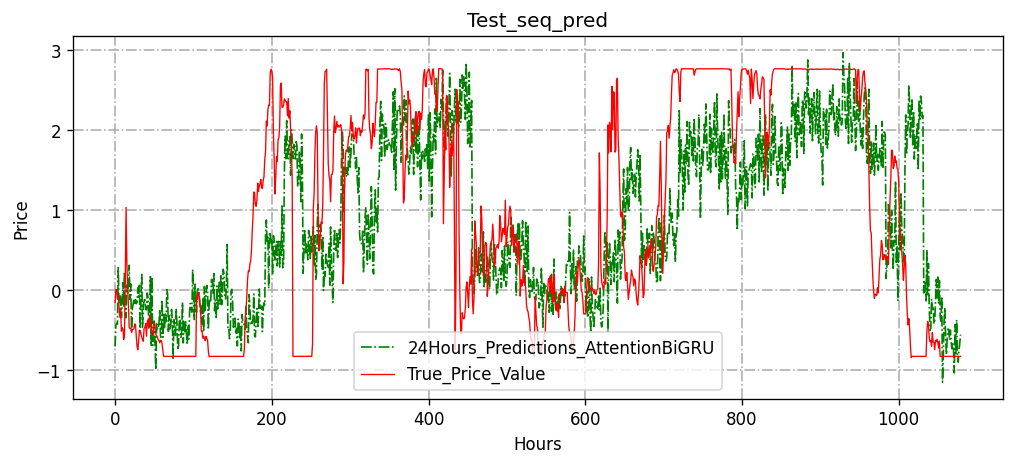

In [110]:
plt.figure(1)
fs = (10,4)
plt.figure(figsize=fs,dpi=120)
xs = np.arange(len(ground_tr))
#xs = np.arange(288*2)
    
plt.title('Test_seq_pred')
plt.xlabel('Hours')
plt.ylabel('Price')
plt.plot(xs, eva_preds, '-.g', linewidth = 1.0, label = '24Hours_Predictions_AttentionBiGRU')
plt.plot(xs, ground_tr, '-r', linewidth = 0.8, label = 'True_Price_Value')


plt.grid(linestyle='-.', linewidth = 1)
plt.legend()
#plt.savefig('Save_figure/forwardGRU_Atten.png', dpi=2600)
plt.show()